In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


## Trends

In [2]:
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/results/2")
ofile_aj = basepath.joinpath("all_jets.pkl")
ofile_waj = basepath.joinpath("where_are_jets.npy")
ofile_ajoa = basepath.joinpath("all_jets_one_array.npy")
ofile_ajot = basepath.joinpath("all_jets_over_time.npy")
ofile_flags = basepath.joinpath("flags.npy")
ofile_padu = basepath.joinpath("props_as_ds_uncat.nc")
ofile_pad = basepath.joinpath("props_as_ds.nc")
props_as_ds_uncat = xr.open_dataset(ofile_padu)
props_as_ds = xr.open_dataset(ofile_pad)

# DST

In [3]:
from CDSK import dynamical_local_indexes

In [4]:
subset = ['Lat', 'Lon', 'Spe', "mean_lev", 'lon_ext', 'width', 'tilt', 'sinuosity', 'int', 'persistence']
jets = props_as_ds.jet.values

In [5]:
X = []
full_varname = []
time_mask1 = props_as_ds.time.dt.year >= 1979
time_mask2 = props_as_ds.time.dt.season == "JJA"
time_mask = time_mask1 & time_mask2
for varname, jet in product(subset, jets):
    if varname == "Lat":
        default_value = 50 if jet == "polar" else 30
    else:
        default_value = 1
    X.append(np.nan_to_num(props_as_ds[varname].sel(jet=jet, time=time_mask).values, nan=default_value))
    full_varname.append(f"{varname}_{jet}")
X = np.vstack(X).T[:, None, :].copy()

In [16]:
full_varname

['Lat_subtropical',
 'Lat_polar',
 'Lon_subtropical',
 'Lon_polar',
 'Spe_subtropical',
 'Spe_polar',
 'mean_lev_subtropical',
 'mean_lev_polar',
 'lon_ext_subtropical',
 'lon_ext_polar',
 'width_subtropical',
 'width_polar',
 'tilt_subtropical',
 'tilt_polar',
 'sinuosity_subtropical',
 'sinuosity_polar',
 'int_subtropical',
 'int_polar',
 'persistence_subtropical',
 'persistence_polar']

In [ ]:
lds = np.zeros(X.squeeze().shape)
thetas = np.zeros_like(lds)
for i in trange(X.shape[-1]):
    ld, theta, _ = dynamical_local_indexes(X[:, :, i], ql=0.98, ld_fit="SDFC", n_jobs=10)
    lds[:, i], thetas[:, i] = ld.squeeze(), theta.squeeze()

In [12]:
np.save("results/tmp/lds.npy", lds)
np.save("results/tmp/thetas.npy", thetas)

In [15]:
thetas.shape

(16192, 20)

In [8]:
ld, theta, _ = dynamical_local_indexes(X[:199, :, 0], ql=0.98, ld_fit="SDFC", n_jobs=5)

/storage/homefs/hb22g102/CDSK-python/CDSK/__dynamical_local_indexes.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return (K + N + Nc - np.sqrt((K + N + Nc) ** 2 - 8 * Nc * K)) / (2 * K)
/storage/homefs/hb22g102/CDSK-python/CDSK/__dynamical_local_indexes.py:318: RuntimeWarning: invalid value encountered in divide
  alpha[:, i, j] = np.sum(where[:, :, i, i] & where[:, :, j, j], 1) / np.sum(where[:, :, i, i], 1)


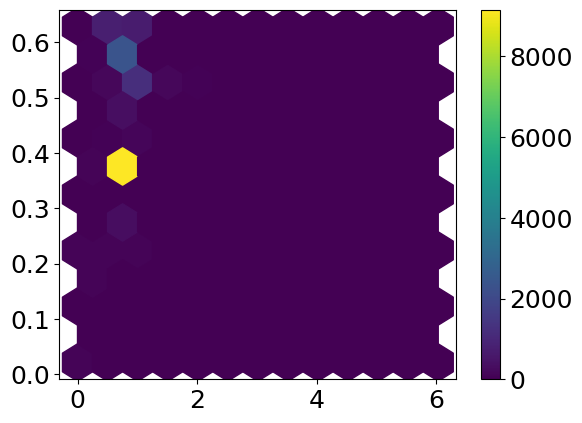

In [25]:
ld_ = ld[:, 0, 0]
ld_[ld_ > 1e7] = 0
im = plt.hexbin(ld_, theta.ravel(), gridsize=12)
plt.colorbar(im)
# plt.plot(ld_, theta.ravel(), "wx")

# Trends

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:514: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


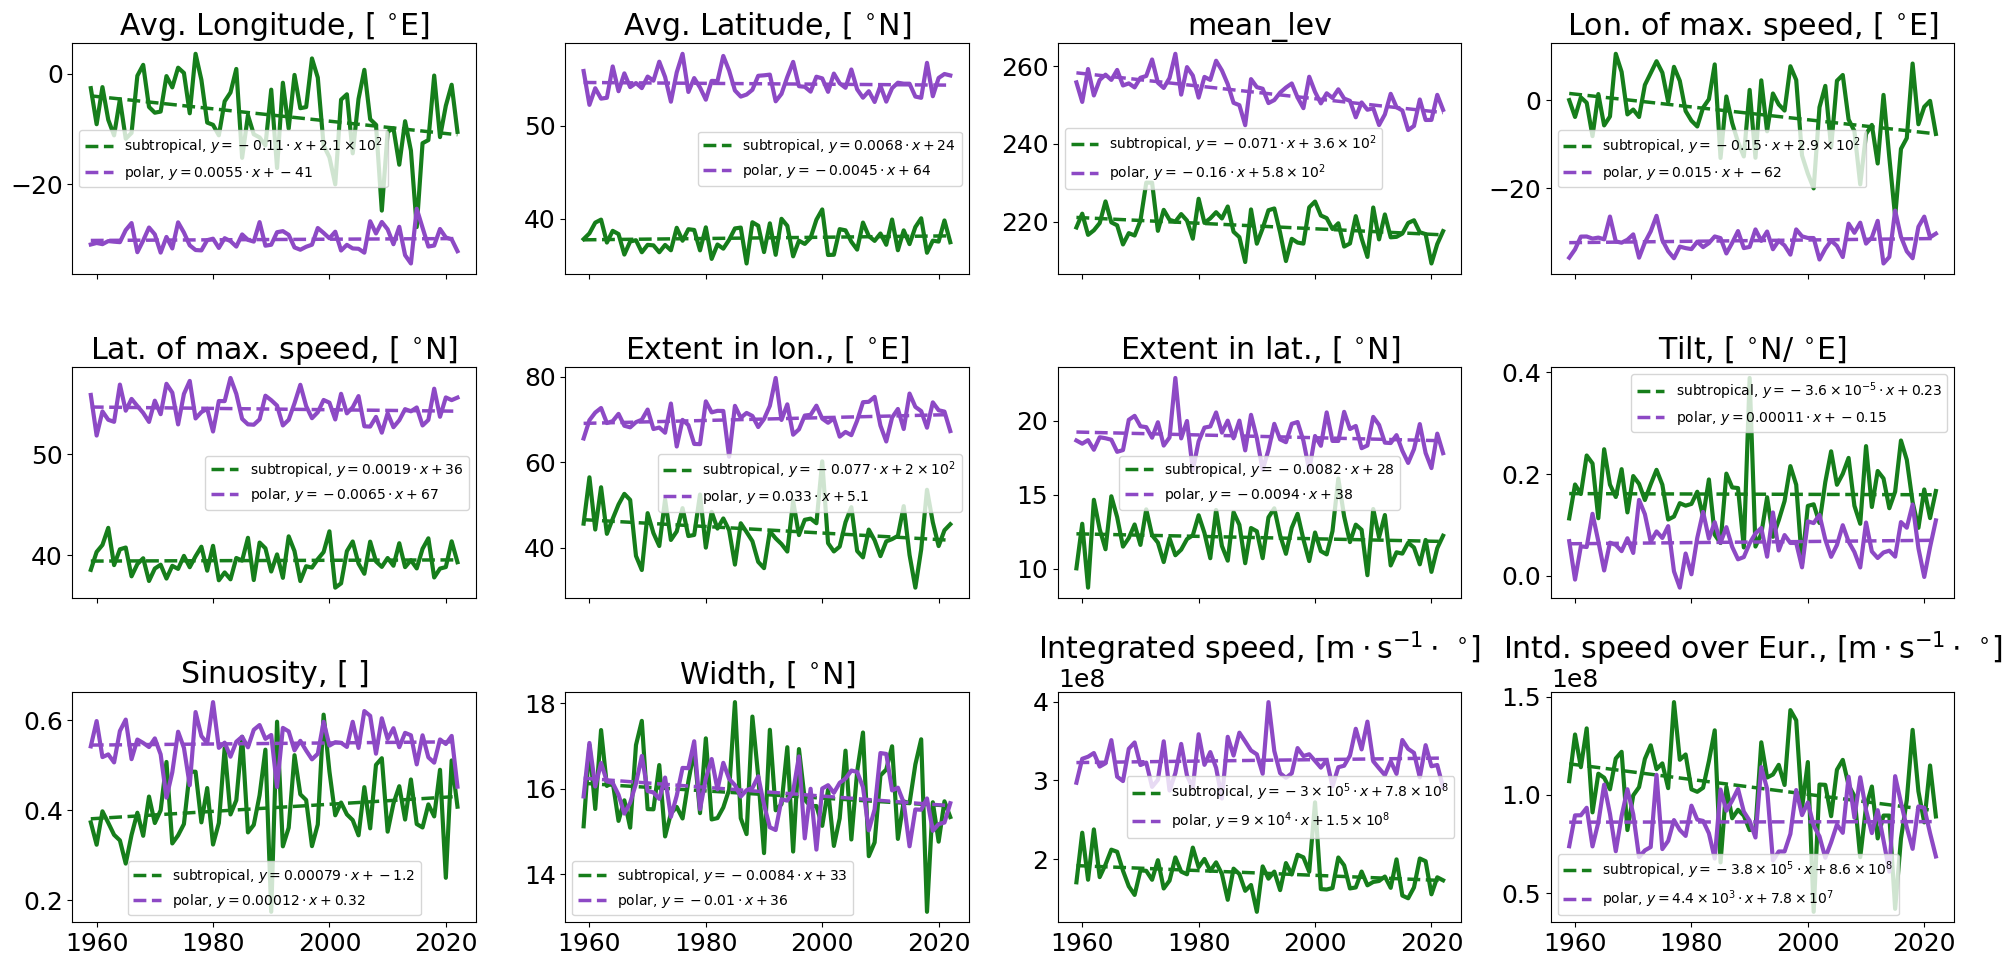

In [16]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [7, 8])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").mean()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS5[j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959_summer.png")

In [8]:
p

Polynomial([86259173.27469,   137661.09687], domain=[1959., 2022.], window=[-1.,  1.], symbol='x')

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:514: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


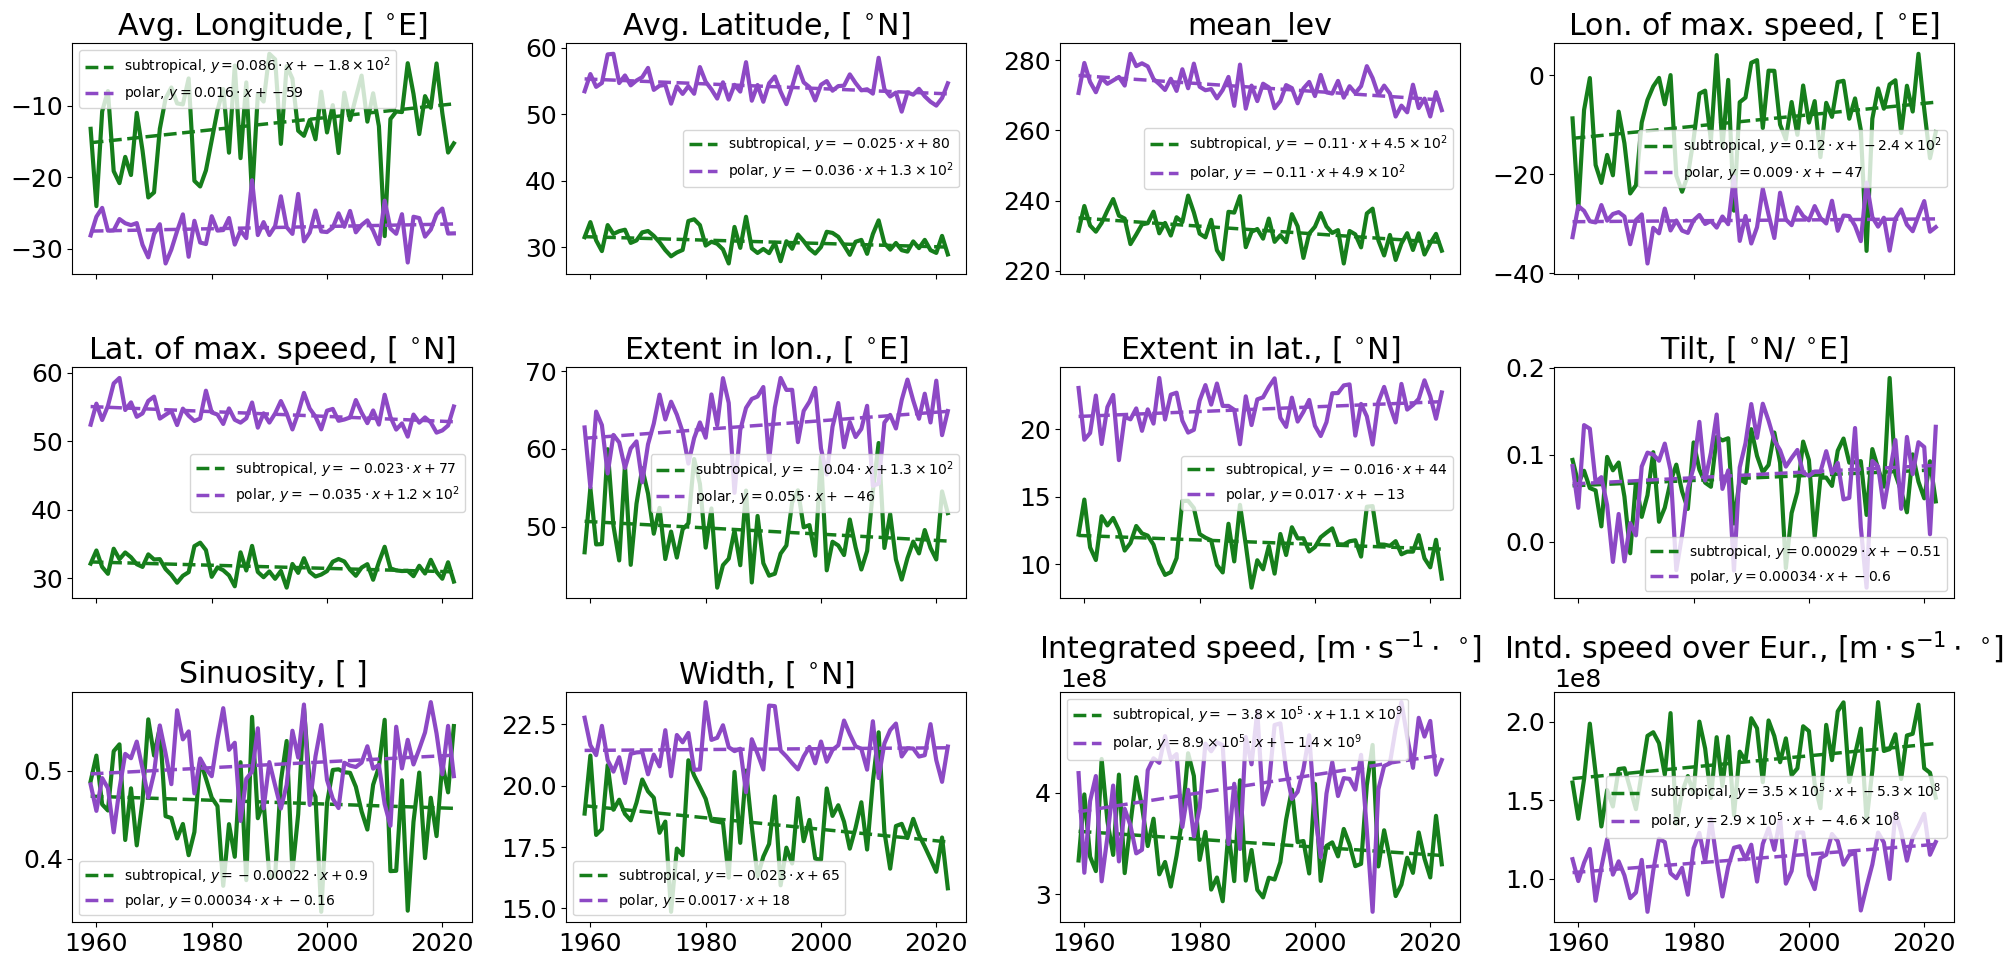

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [12, 1, 2])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").mean()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS5[j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959_winter.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:514: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


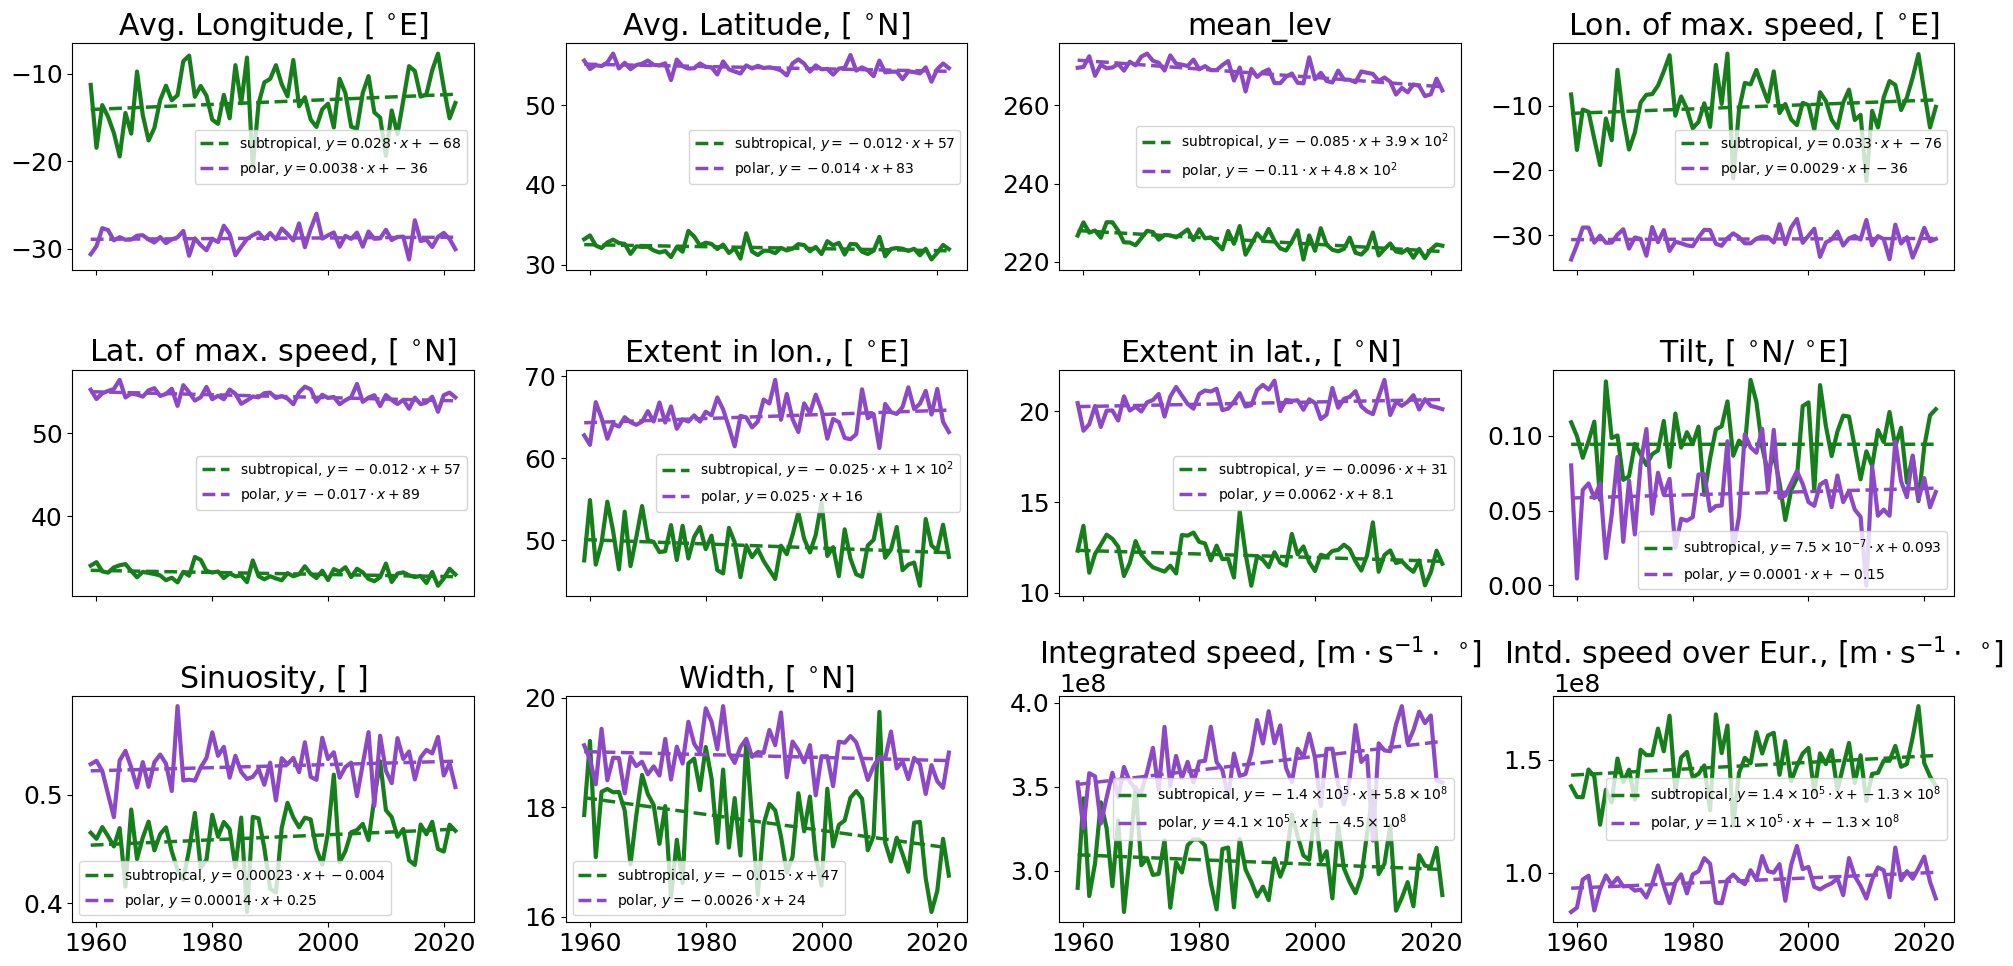

In [18]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
props_as_ds_yearly_hs = props_as_ds.resample(time="1Y").mean()
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS5[j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959_allyear.png")

# Variability

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:514: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


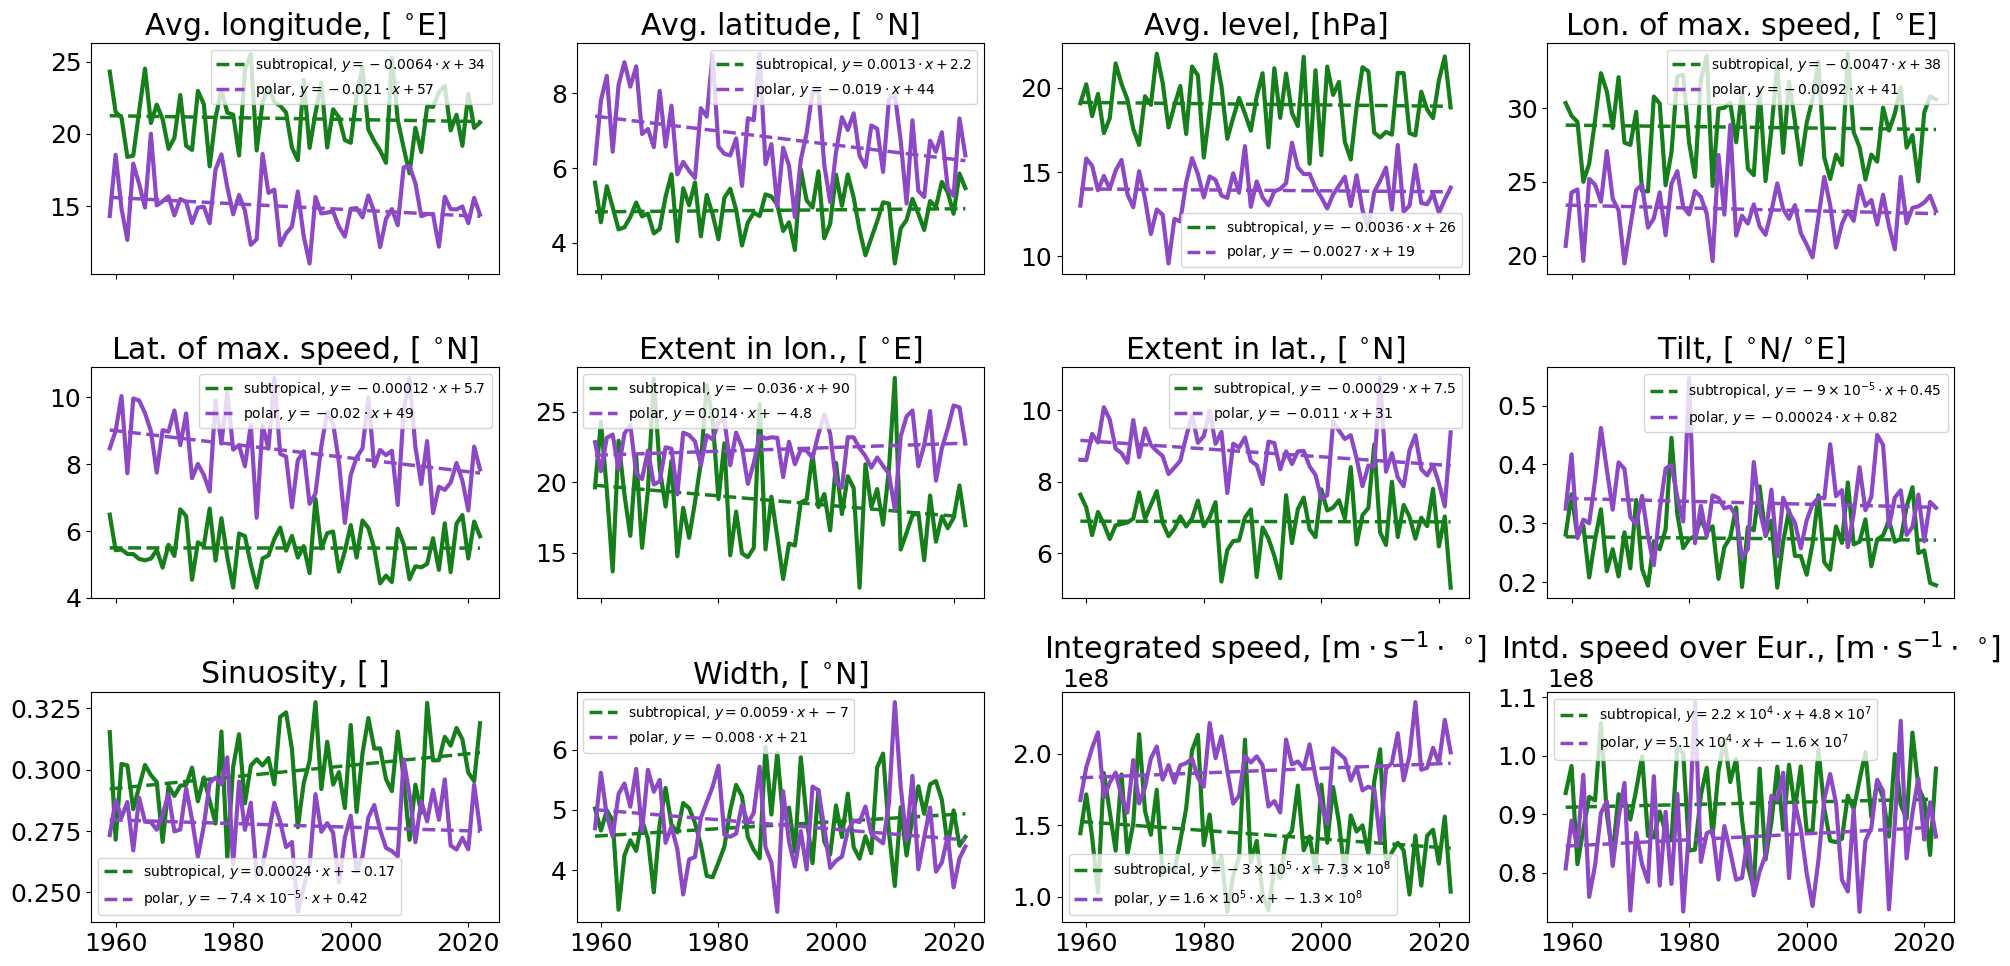

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [12, 1, 2])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").std()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS5[j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_std_post_1959_winter.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:514: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


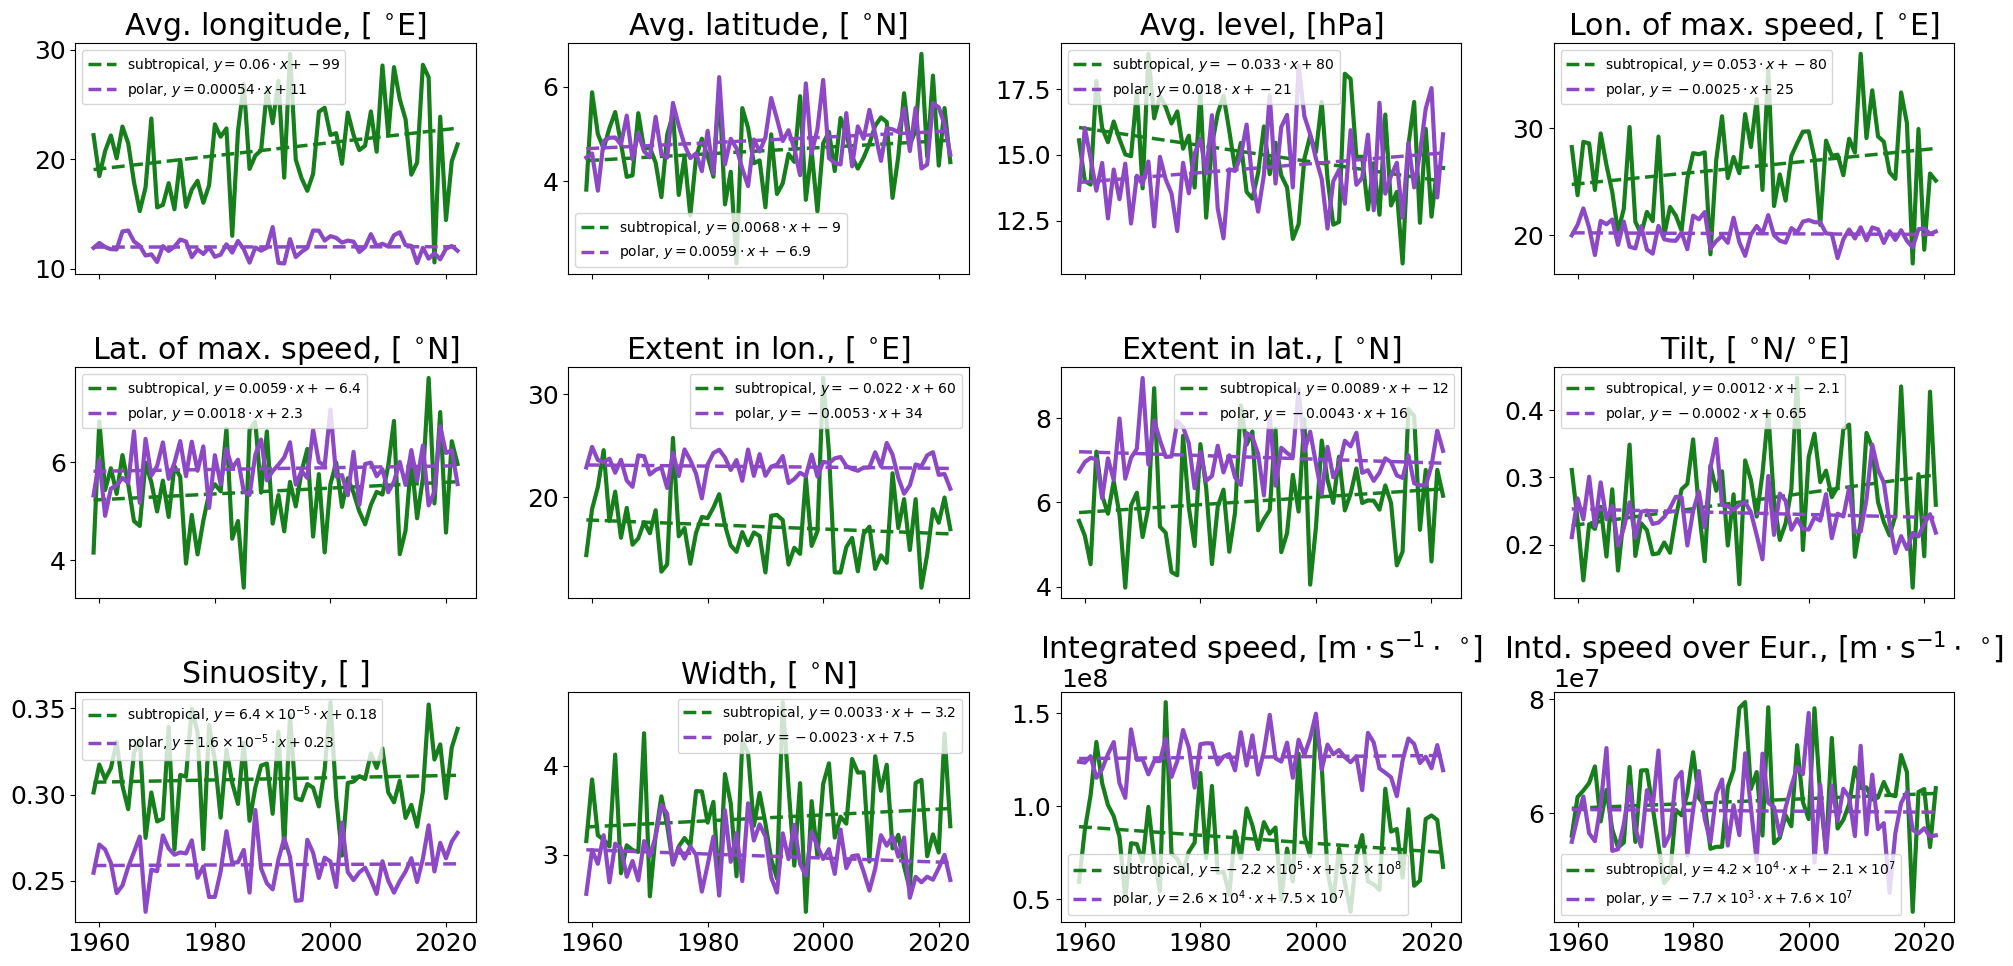

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [6, 7, 8])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").std()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS5[j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_std_post_1959_summer.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:514: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


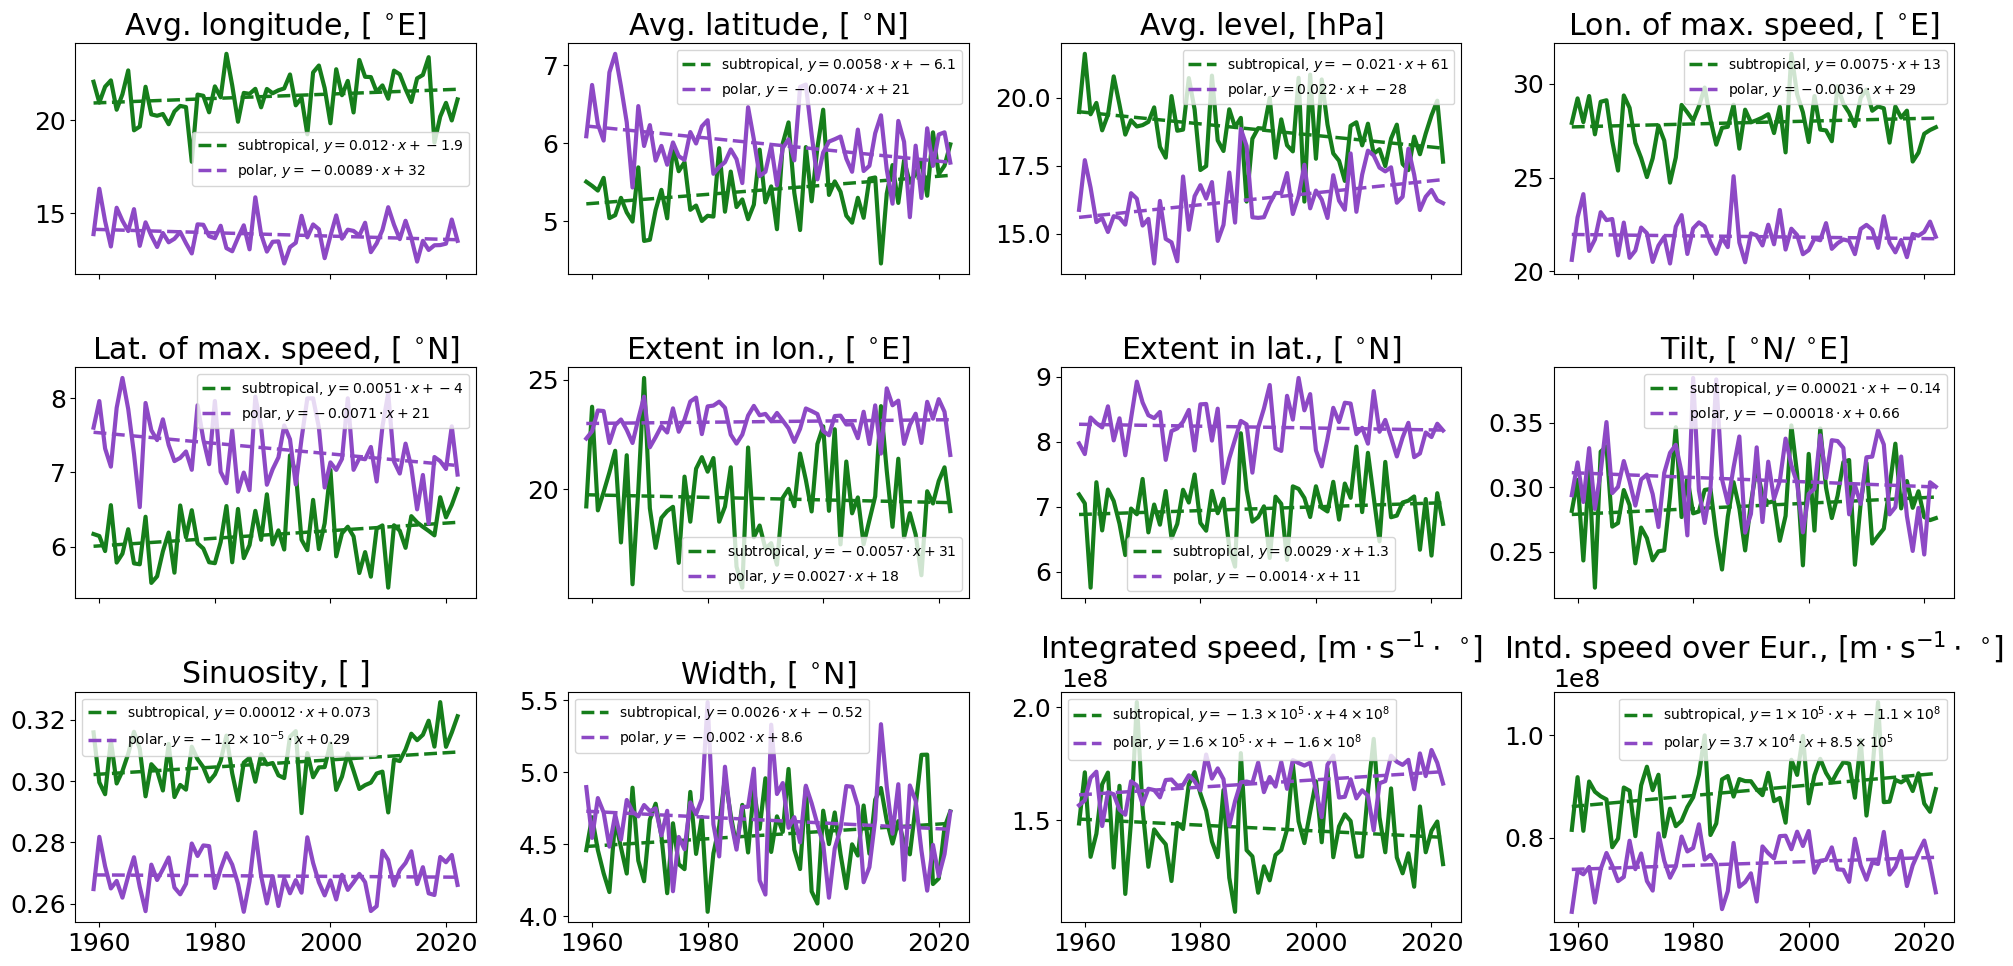

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
props_as_ds_yearly_hs = props_as_ds.resample(time="1Y").std()
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS5[j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_std_post_1959_allyear.png")

# NAO

[[ 1.       0.41002  0.06818]
 [ 0.41002  1.      -0.18765]
 [ 0.06818 -0.18765  1.     ]]


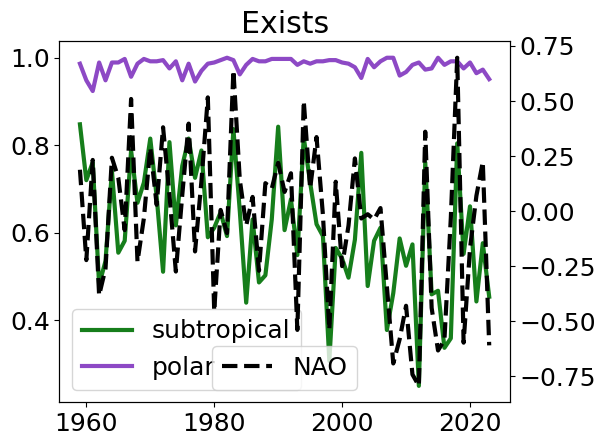

In [ ]:
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [7, 8])
this_props_as_ds = props_as_ds.sel(time=high_summer_mask).resample(time="1M").mean()
corr_time_mask = ~this_props_as_ds["nao"].isnull()
corrs = np.corrcoef(
    np.stack(
        [
            this_props_as_ds["nao"][corr_time_mask].values,
            this_props_as_ds["exists"][corr_time_mask, 0].values,
            this_props_as_ds["exists"][corr_time_mask, 1].values,
        ]
    )
)
fig, ax = plt.subplots(tight_layout=True)
varname = "exists"
for j, jet in enumerate(["subtropical", "polar"]):
    ax.set_title(f"{PRETTIER_VARNAME[varname]}")
    this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
    ax.plot(x, this_da.values, lw=3, color=COLORS5[j], label=jet)
twinax = ax.twinx()
twinax.plot(
    x,
    props_as_ds_yearly_hs["nao"][time_mask],
    lw=3,
    color="black",
    label="NAO",
    ls="dashed",
)
ax.legend().set_zorder(102)
twinax.legend(loc="lower center")
print(corrs)

# Correlations

In [ ]:
props_as_ds_late = props_as_ds.sel(time=props_as_ds.time.dt.year >= 1959)
props_as_ds_late["anti_pv_activity"] = (
    "time",
    ds_pvs["anti"].sum(dim=["lon", "lat"]).values,
)
props_as_ds_late["cycl_pv_activity"] = (
    "time",
    ds_pvs["cycl"].sum(dim=["lon", "lat"]).values,
)
props_as_ds_late["nao"] = nao_summer.sel(time=nao_summer.time.dt.year >= 1959)
props_as_ds_late["n_jets"] = (~props_as_ds_uncat["mean_lat"].isnull()).sum(dim="jet")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


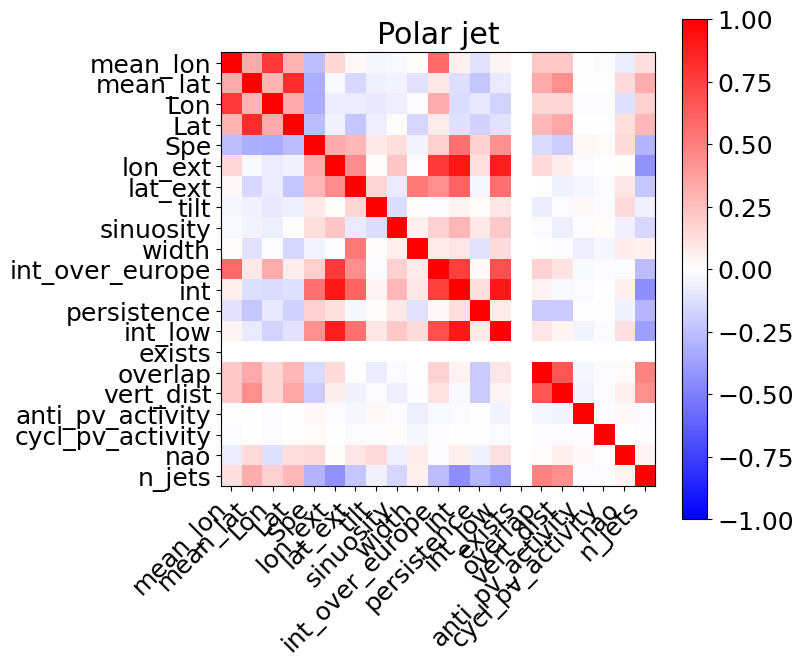

In [ ]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="polar").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
    ]:
        to_concat.append(da.sel(jet="polar").values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("Polar jet")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_polar.png")

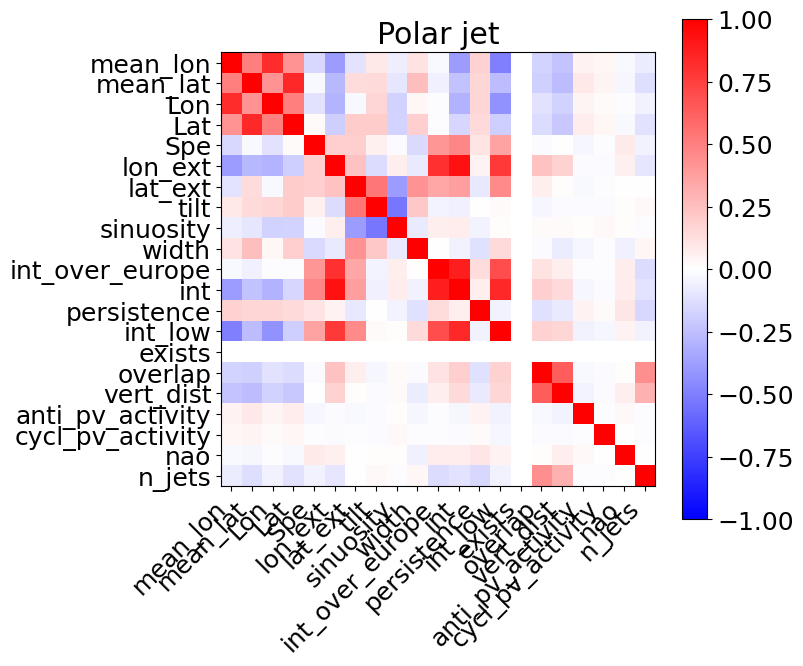

In [ ]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="subtropical").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
    ]:
        to_concat.append(da.sel(jet="subtropical").values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("Polar jet")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_subtropical.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


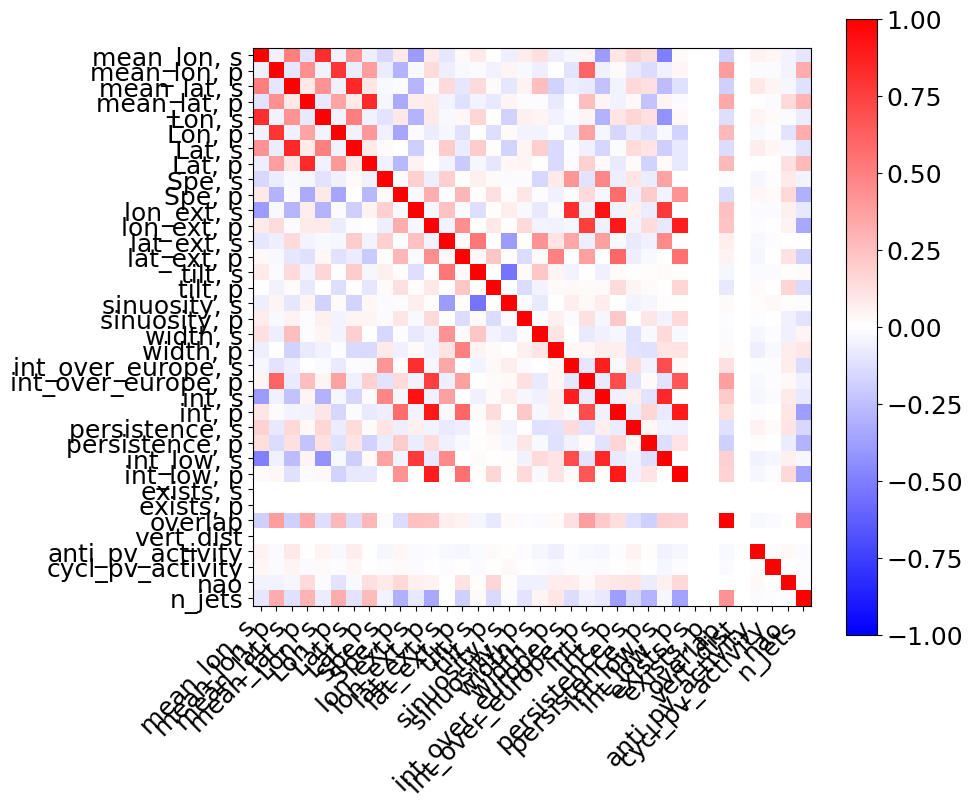

In [ ]:
to_concat = []
ticks = []
valids = props_as_ds_late["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).values[valids])
            ticks.append(f"{varname}, {jet[0]}")
    else:
        to_concat.append(np.roll(da.values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(9, 8))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(ticks)), ticks)
_ = ax.set_xticks(np.arange(0, len(ticks)), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full.png")

# Seasonal variability ?

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
props_as_ds_yearly_hs = props_as_ds.resample(time="1Y").mean()
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS5[j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959_allyear.png")

In [22]:
props_as_ds

<xarray.Dataset>
Dimensions:          (time: 121264, jet: 2)
Coordinates:
  * time             (time) datetime64[ns] 1940-01-01 ... 2022-12-31T18:00:00
  * jet              (jet) <U11 'subtropical' 'polar'
Data variables: (12/16)
    mean_lon         (time, jet) float64 -40.48 -32.42 -39.98 ... nan -26.73
    mean_lat         (time, jet) float64 34.53 70.55 34.14 ... 47.95 nan 47.63
    Lon              (time, jet) float64 -45.5 -38.0 -31.0 ... -0.5 nan 14.5
    Lat              (time, jet) float64 40.0 71.0 39.0 60.75 ... 55.0 nan 57.5
    Spe              (time, jet) float64 94.53 59.27 84.84 ... 86.46 nan 77.21
    lon_ext          (time, jet) float64 72.0 71.5 81.5 ... 102.5 nan 108.0
    ...               ...
    int_over_europe  (time, jet) float64 3.216e+07 2.39e+07 ... nan 2.302e+08
    int              (time, jet) float64 5.215e+08 1.338e+08 ... nan 7.595e+08
    persistence      (time, jet) float64 11.75 4.0 11.75 2.25 ... 6.0 nan 6.0
    int_low          (time, jet) float64 1.764e+08 2.764e+07 ... nan 2.567e+08
    mean_lev         (time, jet) float64 244.1 290.3 236.6 ... 239.9 nan 226.0
    int_ratio        (time, jet) float64 0.3384 0.2066 0.3165 ... nan 0.338

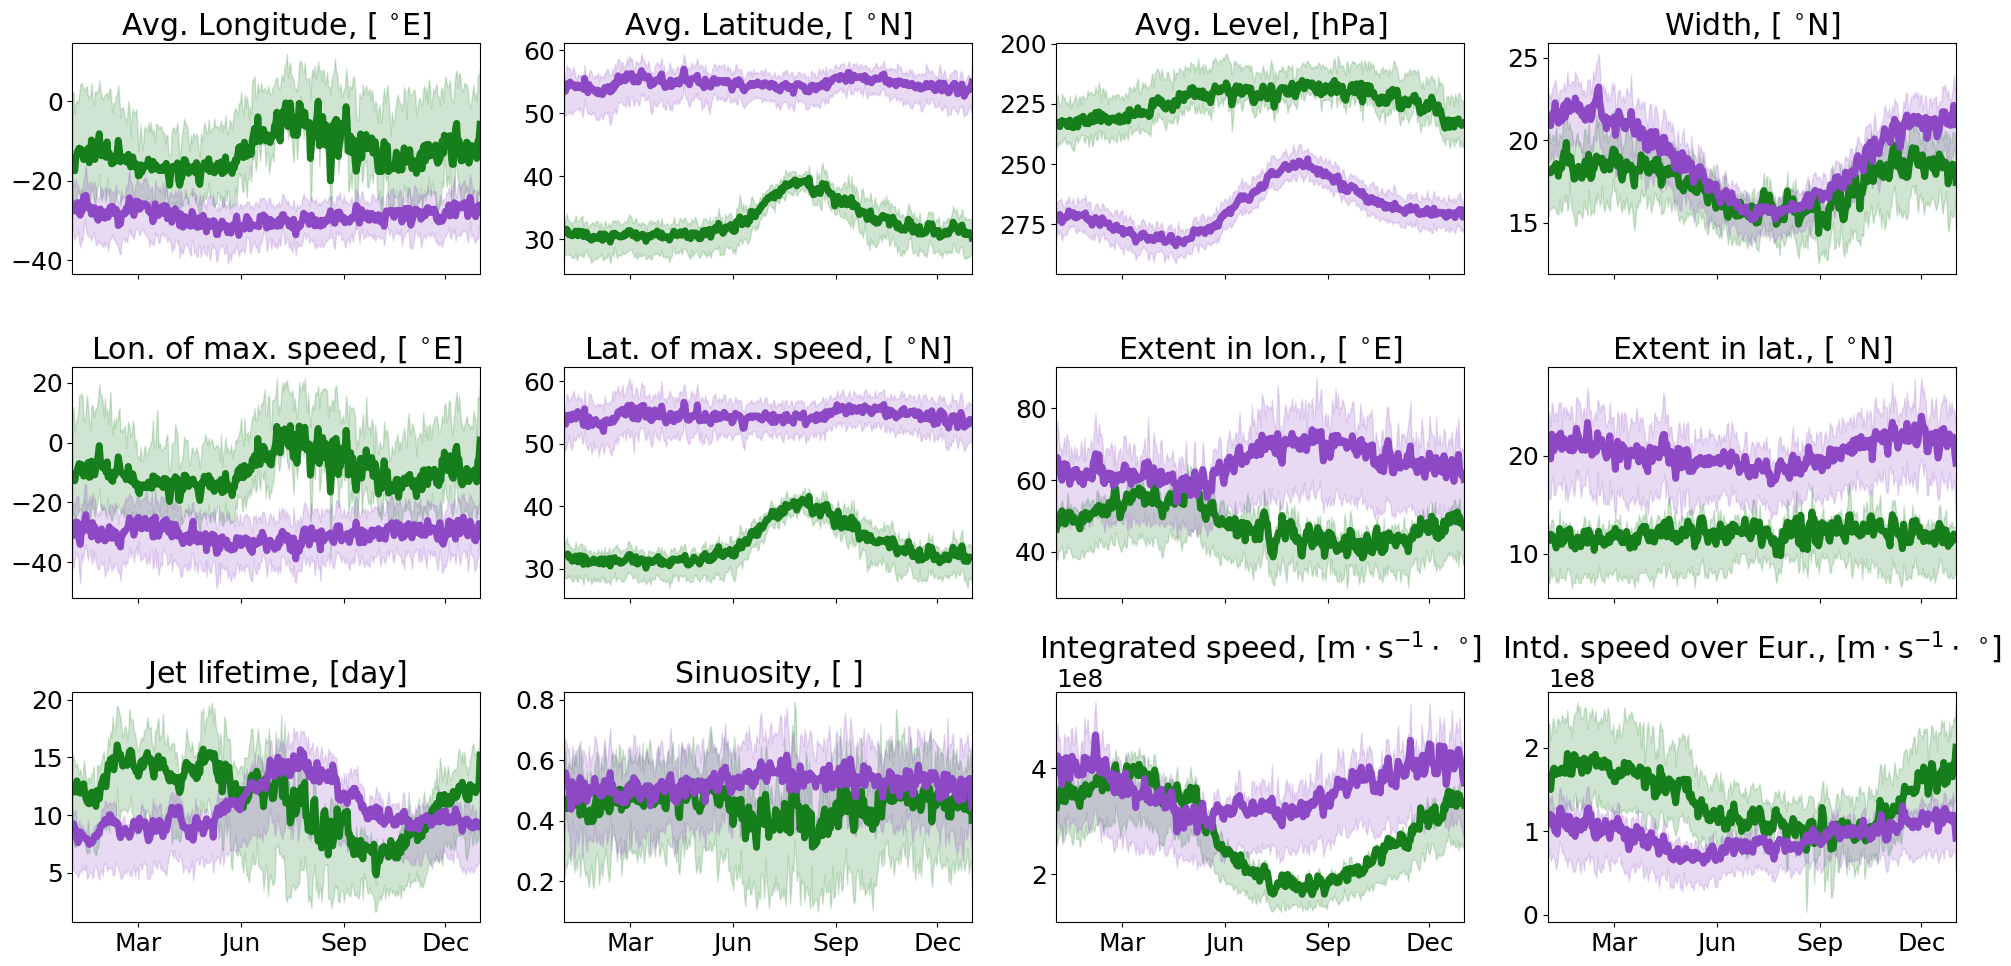

In [27]:
from matplotlib.dates import DateFormatter, MonthLocator

data_vars = ["mean_lon", "mean_lat", "mean_lev", "width", "Lon", "Lat", "lon_ext", "lat_ext", "persistence", "sinuosity", "int", "int_over_europe"]

fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
for varname, ax in zip(data_vars, axes.ravel()):
    gb = props_as_ds[varname].groupby("time.dayofyear")
    x = list(gb.groups.keys())
    x = DATERANGEPL_EXT[x]
    ys = gb.mean().values
    qs = gb.quantile(q=[0.33, 0.66]).values
    for i in range(2):
        ax.fill_between(x, qs[:, i, 0], qs[:, i, 1], color=COLORS5[i], alpha=0.2)
        ax.plot(x, ys[:, i], lw=5, color=COLORS5[i])
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal.png")

# Demo: double anim

In [ ]:
r1 = len(da_s.lon) / len(da_s.lat)
r2 = 1
height = 4
wspace = 0.04
cbar_size = 0.05
fig = plt.figure(
    figsize=(height * (r1 + r2 + 2 * cbar_size + 3 * wspace), height), dpi=90
)
gs = GridSpec(
    1,
    5,
    width_ratios=(r1, cbar_size, 4 * wspace, r2, cbar_size),
    wspace=0.02,
    figure=fig,
)

fig.add_subplot(gs[2], visible=False)
ax_contourf = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax_contourf.set_extent(
    exp_s.region,
    crs=ccrs.PlateCarree(),
)
ax_contourf.add_feature(COASTLINE)
cs = ax_contourf.contourf(
    da_s.lon.values, da_s.lat.values, da_s[tsteps[0]].values, **kwargs_contourf
)
cax = fig.add_subplot(gs[1])
fig.colorbar(cs, cax=cax)

ax_trajectory = fig.add_subplot(gs[3])
# ax_trajectory.plot([1, 2])
kwargs_trajectory = dict(
    cmap=mpl.colormaps["gray_r"], norm=Normalize(np.amin(thesepops), np.amax(thesepops))
)
xlims = [
    np.amin(coords[~outermask][:, 0]) - 0.8,
    np.amax(coords[~outermask][:, 0]) + 0.8,
]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
fig, ax_trajectory = splots.plot_map(
    coords,
    populations,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors="black",
    cmap="Greys",
    alphas=alphas,
    linewidths=0,
    fig=fig,
    ax=ax_trajectory,
)
cax = fig.add_axes([0.67, 0.84, 0.06, 0.04])
im = ScalarMappable(**kwargs_trajectory)
fig.colorbar(im, cax=cax, orientation="horizontal", ticks=[])
cax.text(-5, 0.35, "0", ha="center", va="center")
max_pop = np.amax(populations)
cax.text(max_pop + 9, 0.35, f"{max_pop}", ha="center", va="center")

lc = LineCollection(segments, cmap="magma", norm=norm)
lc.set_array(np.repeat(np.arange(len(traj) - 1), repeats=reps))
lc.set_linewidth(3)
lc = ax_trajectory.add_collection(lc)
cax = fig.add_subplot(gs[4])
cbar = fig.colorbar(lc, label=f"Days of summer {YEARSPL[yearidx]}", cax=cax)
list_of_days = np.asarray([0, 14 * 4, 30 * 4, 44 * 4, 61 * 4, 75 * 4, 91 * 4 + 3])

pretty_list_of_days = (
    da.time[yearidx * 92 * 4 + list_of_days].dt.strftime("%b %d").values
)
cbar.ax.set_yticks(list_of_days, labels=pretty_list_of_days)
cbar.ax.invert_yaxis()
ax_trajectory.set_xlim(xlims)
ax_trajectory.set_ylim(ylims)

jets = all_jets[tsteps[0]]
lines = []
for j in range(3):
    try:
        jet = jets[j]
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        newy = p(x)
    except IndexError:
        x, newy, s = [], [], []

    lines.append(ax_contourf.plot(x, newy, color="dimgray", lw=4)[0])


def animate(i):
    global cs
    global lines
    global lc
    for c in cs.collections:
        c.remove()
    cs = ax_contourf.contourf(
        da_s.lon.values, da_s.lat.values, da_s[tsteps[i]].values, **kwargs_contourf
    )
    jets = all_jets[tsteps[i]]
    for j in range(3):
        try:
            jet = jets[j]
            x, y, s = jet.T
        except IndexError:
            x, y, s = [], [], []
        lines[j].set_data(x, y)
    if i > 1:
        to_be_set_visible = np.sum(reps[:i])
        lws = np.zeros(len(segments))
        lws[:to_be_set_visible] = 4
        lc.set_lw(lws)
    else:
        lc.set_lw(0.0)
    fig.suptitle(titles[i])
    return cs, lines, lc


ani = FuncAnimation(fig, animate, frames=np.arange(len(tsteps)))
ani.save("Figures/double_anim.gif", dpi=200, fps=5)

# Demo: simple anim

In [ ]:
times[0].dt.strftime("%d-%m-%YT%H:00").item()

'01-06-1999T00:00'